In [1]:
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.applications.vgg16 import VGG16 as PretrainedModel, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

In [2]:
# Data from: https://mmspg.epfl.ch/downloads/food-image-datasets/
# Download the zip file saved in the Drive 
!pip install -U -q PyDrive

#File ID
zip_id = '1C8Fz--k6a9wmqLLif1FvEQcDOYLFqiYJ'

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import zipfile, os

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download the zip file
myzip = drive.CreateFile({'id': zip_id})
myzip.GetContentFile('Food-5K.zip')

In [3]:
# verified that the data has been downloaded
!ls

adc.json  Food-5K.zip  sample_data


In [4]:
# let's unzip the data
# -qq don't show ouput
!unzip -qq -o Food-5K.zip

In [5]:
# Show unzip data
!ls

adc.json  Food-5K  Food-5K.zip	__MACOSX  sample_data


In [6]:
# show training data
# images starting with 0 and images starting with 1

# we'll use thr traing directory for training (Food-5K/training) and 
# validation directory for test
!ls Food-5K

evaluation  training  validation


In [7]:
# Move directory outside the main folder
!mv Food-5K/* .

# Show moved directory
!ls

adc.json    Food-5K	 __MACOSX     training
evaluation  Food-5K.zip  sample_data  validation


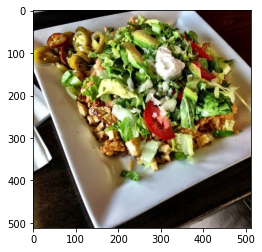

In [8]:
# Show sample data: check out an image
plt.imshow(image.load_img('training/1_1191.jpg'))
plt.show()

In [9]:
# now let's set up the proper directory structure
# let start with creating the appropriate directories
# Make appropriate directories 
!mkdir data                           # parent dir
!mkdir data/train
!mkdir data/test
!mkdir data/train/nonfood
!mkdir data/train/food
!mkdir data/test/nonfood
!mkdir data/test/food
!ls

adc.json  evaluation  Food-5K.zip  sample_data	validation
data	  Food-5K     __MACOSX	   training


In [10]:
# now let's move the data to the appropriate directories
# Move the images
# Note: we will consider 'training' to be the train set
#       'validation' folder will be the test set
#       ignore the 'evaluation' set
!mv training/0*.jpg data/train/nonfood
!mv training/1*.jpg data/train/food
!mv validation/0*.jpg data/test/nonfood
!mv validation/1*.jpg data/test/food

# set up path for training and validation
train_path = 'data/train'
valid_path = 'data/test'

In [11]:
# process the image : standarization
# These images are pretty big and of different sizes
# Let's load them all in as the same (smaller) size
IMAGE_SIZE = [200, 200]

# useful for getting number of files
image_files = glob(train_path + '/*/*.jpg')
valid_image_files = glob(valid_path + '/*/*.jpg')
print('Number of images for training: ', len(image_files))
print('Number of images for validation: ', len(valid_image_files))

Number of images for training:  3000
Number of images for validation:  1000


In [12]:
# useful for getting number of classes
folders = glob(train_path + '/*')
print(folders)

['data/train/food', 'data/train/nonfood']


In [13]:
# STAGE 1
# let's create an instance of the VVG16 using our IMAGE_SIZE
ptm = PretrainedModel(
    input_shape=IMAGE_SIZE + [3],
    weights='imagenet',
    include_top=False)

# let's freeze the VVG16 instance stage 1 we created 
# for pretrained model weights
ptm.trainable = False

58900480/58889256 [==============================] - 1s 0us/step


In [14]:
# STAGE 2 
# let's create our classifier
# map the data into feature vectors

# Keras image data generator returns classes one-hot encoded
# K = len(folders) # number of classes
x = Flatten()(ptm.output)

# create a model object
model = Model(inputs=ptm.input, outputs=x)

# view the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0     

In [15]:
# create an instance of ImageDataGenerator
gen = ImageDataGenerator(preprocessing_function=preprocess_input)

batch_size = 128

# create generators
train_generator = gen.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  batch_size=batch_size,
  class_mode='binary',
)

valid_generator = gen.flow_from_directory(
  valid_path,
  target_size=IMAGE_SIZE,
  batch_size=batch_size,
  class_mode='binary',
)

# Number of training and testing images
Ntrain = len(image_files)
Nvalid = len(valid_image_files)

Found 3000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [17]:
# Figure out the output size or the shape of what i'm getting out
# before flattening
feat = model.predict(np.random.random([1] + IMAGE_SIZE + [3]))
D = feat.shape[1]

# let's creat the features and targets
X_train = np.zeros((Ntrain, D))
Y_train = np.zeros(Ntrain)
X_valid = np.zeros((Nvalid, D))
Y_valid = np.zeros(Nvalid)

In [18]:
# right now X_train and Y_train are just a bunch of 0s
# let's populate X_train and Y_train
i = 0
for x, y in train_generator:
  # get features
  features = model.predict(x)
  
  # size of the batch (may not always be batch_size)
  sz = len(y)
  
  # assign to X_train and Ytrain
  X_train[i:i + sz] = features
  Y_train[i:i + sz] = y
  
  # increment i
  i += sz
  print(i)

  if i >= Ntrain:
    print('breaking now')
    break
print(i)

128
256
384
512
640
768
896
1024
1152
1280
1408
1536
1664
1792
1920
2048
2176
2304
2432
2560
2688
2816
2944
3000
breaking now
3000


In [19]:
# populate X_valid and Y_valid
i = 0
for x, y in valid_generator:
  # get features
  features = model.predict(x)
  
  # size of the batch (may not always be batch_size)
  sz = len(y)
  
  # assign to X_train and Ytrain
  X_valid[i:i + sz] = features
  Y_valid[i:i + sz] = y
  
  # increment i
  i += sz

  if i >= Nvalid:
    print('breaking now')
    break
print(i)

breaking now
1000


In [20]:
# let's check the value to see if normalization is going to 
# be helpfull or needed
X_train.max(), X_train.min()

(650.8260498046875, 0.0)

In [22]:
#let's now normalized the X-features data
# after normalization the mean bcome 0
# and the devioation become 1
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train2 = scaler.fit_transform(X_train)
X_valid2 = scaler.transform(X_valid)

# let's check again
X_train2.max(), X_train2.min()

(51.20962468245005, -2.3316473640092923)

In [23]:
# Now let's try the scikit-learn logistic regression
# we are getting a high accuray from logistic regression 
# because of the power of VVG -- just running the image VVG helped
from sklearn.linear_model import LogisticRegression
logr = LogisticRegression()
logr.fit(X_train2, Y_train)
print(logr.score(X_train2, Y_train))
print(logr.score(X_valid2, Y_valid))

1.0
0.979


In [25]:
# let's do the same thing but with logistic regression in Tensorflow
i = Input(shape=(D,))
x = Dense(1, activation='sigmoid')(i)
linearmodel = Model(i, x)

linearmodel.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

# train the model
r = linearmodel.fit(
    X_train2, Y_train,
    batch_size=128,
    epochs=10,
    validation_data=(X_valid2, Y_valid),
)

# we can see that we get similar result and about the same value 
# of accuracy both logistic regression in Tensorflow 
# and scikit-learn logistic regression

Epoch 1/10
24/24 [==============================] - 1s 16ms/step - loss: 0.1758 - accuracy: 0.9253 - val_loss: 0.0635 - val_accuracy: 0.9750
Epoch 2/10
24/24 [==============================] - 0s 7ms/step - loss: 0.0121 - accuracy: 0.9973 - val_loss: 0.0527 - val_accuracy: 0.9820
Epoch 3/10
24/24 [==============================] - 0s 7ms/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 0.0510 - val_accuracy: 0.9820
Epoch 4/10
24/24 [==============================] - 0s 7ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.0501 - val_accuracy: 0.9800
Epoch 5/10
24/24 [==============================] - 0s 8ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0496 - val_accuracy: 0.9810
Epoch 6/10
24/24 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0497 - val_accuracy: 0.9820
Epoch 7/10
24/24 [==============================] - 0s 8ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0498 - val_accuracy: 0.9820
Epoch 8/10
24/24 [=

In [26]:
# When it comes to transfer learning
# performing it with and without augmentation provide similar
# result in term of accuracy.

# the only thing that differs is how long it took the model
# to precess the data - 
# too slow of process with augmenation
# very fast using VVG 16